In [2]:
!pip install -q --upgrade librosa==0.10.1 soundfile tqdm

In [3]:
import os, pathlib, numpy as np, pandas as pd
import librosa, soundfile as sf
from tqdm.notebook import tqdm

# Audio-processing parameters
SR        = 22_050    # target sampling rate
N_MFCC    = 40        # number of MFCC coefficients
DUR       = 4.0       # UrbanSound8K clips are ≤ 4 s
MAX_LEN   = int(SR * DUR)

DATA_ROOT = pathlib.Path('/kaggle/input/urbansound8k')
META_CSV  = DATA_ROOT / 'UrbanSound8K.csv'

assert META_CSV.exists(), "Meta file not found—did you attach the dataset?"
meta_df = pd.read_csv(META_CSV)
meta_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
def path_from_row(row):
    return DATA_ROOT / f"fold{row['fold']}" / row['slice_file_name']

In [5]:
def extract_mfcc(path, sr=SR, n_mfcc=N_MFCC, max_len=MAX_LEN):

    y, _ = librosa.load(path, sr=sr)           # resample to target SR
    if len(y) < max_len:                       # pad if shorter than 4 s
        y = np.pad(y, (0, max_len - len(y)))
    else:                                      # or cut if longer
        y = y[:max_len]

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = (mfcc - mfcc.mean(axis=1, keepdims=True)) / \
           (mfcc.std(axis=1, keepdims=True) + 1e-6)
    return mfcc.astype(np.float32)

In [6]:
from sklearn.preprocessing import LabelEncoder

# 0) Prepare label-encoder (maps class-names → 0-…-9)  
le = LabelEncoder()
le.fit(meta_df['class'])                     # 10 class names
print("Classes:", list(le.classes_))

# 1) Storage lists
X_list, y_list = [], []

# 2) Loop over the CSV
for _, row in tqdm(meta_df.iterrows(), total=len(meta_df)):
    wav_path = path_from_row(row)
    mfcc     = extract_mfcc(wav_path)        # (n_mfcc, T)

    X_list.append(mfcc)
    y_list.append(le.transform([row['class']])[0])   # numeric label

# 3) To numpy
X = np.stack(X_list)                         # (N, n_mfcc, T)
y = np.array(y_list, dtype=np.int64)         # (N,)

# 4) Add “channel” dim so Keras CNN can use it: (N, n_mfcc, T, 1)
X = X[..., np.newaxis]

print("Feature tensor:", X.shape, "dtype:", X.dtype)
print("Label vector:  ", y.shape, "min–max:", y.min(), y.max())

Classes: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


  0%|          | 0/8732 [00:00<?, ?it/s]

Feature tensor: (8732, 40, 173, 1) dtype: float32
Label vector:   (8732,) min–max: 0 9


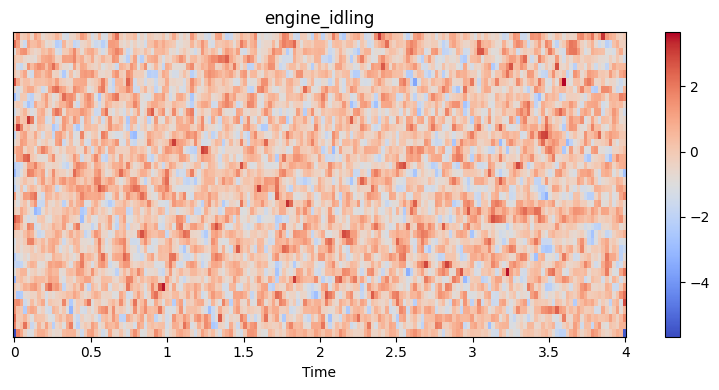

In [7]:
# peek at one example
import matplotlib.pyplot as plt
idx = 123   # any index
plt.figure(figsize=(8, 4))
librosa.display.specshow(X[idx].squeeze(), sr=SR, x_axis='time')
plt.title(le.inverse_transform([y[idx]])[0])
plt.colorbar(); plt.tight_layout()

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (InputLayer, Conv2D, BatchNormalization,
                                     Activation, MaxPooling2D, Dropout,
                                     Flatten, Dense)
import tensorflow as tf

# One-hot encode the integer labels
num_classes = len(le.classes_)
y_cat = to_categorical(y, num_classes)

# 80 / 20 stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.20, random_state=42, stratify=y)

print("Train:", X_train.shape, y_train.shape, "\nVal  :", X_val.shape, y_val.shape)

# Build a lightweight 2-D CNN that treats MFCCs like an ‘image’
time_steps = X.shape[2]          # the temporal dimension after MFCC
model = Sequential([
    InputLayer(input_shape=(N_MFCC, time_steps, 1)),

    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D((2, 2)), Dropout(0.25),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D((2, 2)), Dropout(0.25),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D((2, 2)), Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'), Dropout(0.40),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

2025-05-27 21:43:10.251128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748382190.511066      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748382190.586508      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train: (6985, 40, 173, 1) (6985, 10) 
Val  : (1747, 40, 173, 1) (1747, 10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1748382205.034723      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748382205.035421      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 40, 173, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 173, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 40, 173, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 20, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 86, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 86, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 20, 86, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 10, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 21, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 21, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 13440)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,720,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,815,306 (6.92 MB)

 Trainable params: 1,814,858 (6.92 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation accuracy: {val_acc:.2%}")

Epoch 1/60


I0000 00:00:1748382211.051790     122 service.cc:148] XLA service 0x7853a0013220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748382211.052790     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748382211.052808     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748382211.532223     122 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748382217.525565     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 - 19s - 86ms/step - accuracy: 0.1576 - loss: 2.6241 - val_accuracy: 0.1145 - val_loss: 2.2903 - learning_rate: 0.0010
Epoch 2/60
219/219 - 2s - 11ms/step - accuracy: 0.1731 - loss: 2.1357 - val_accuracy: 0.1151 - val_loss: 2.2838 - learning_rate: 0.0010
Epoch 3/60
219/219 - 2s - 10ms/step - accuracy: 0.1754 - loss: 2.1130 - val_accuracy: 0.1740 - val_loss: 2.1829 - learning_rate: 0.0010
Epoch 4/60
219/219 - 2s - 11ms/step - accuracy: 0.1741 - loss: 2.1111 - val_accuracy: 0.2072 - val_loss: 2.0602 - learning_rate: 0.0010
Epoch 5/60
219/219 - 2s - 10ms/step - accuracy: 0.1795 - loss: 2.0962 - val_accuracy: 0.1517 - val_loss: 2.1971 - learning_rate: 0.0010
Epoch 6/60
219/219 - 2s - 10ms/step - accuracy: 0.1738 - loss: 2.0914 - val_accuracy: 0.2061 - val_loss: 2.0294 - learning_rate: 0.0010
Epoch 7/60
219/219 - 2s - 10ms/step - accuracy: 0.1759 - loss: 2.0876 - val_accuracy: 0.1981 - val_loss: 2.0791 - learning_rate: 0.0010
Epoch 8/60
219/219 - 2s - 10ms/step - accuracy: 0.1797 - l

In [10]:
# Transfer Learning

In [11]:
!pip install -q --upgrade tensorflow_hub

import tensorflow_hub as hub
import tensorflow as tf

# Load the YAMNet Keras model from TF-Hub (weights ≈ 13 MB, will download once)
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet = hub.KerasLayer(yamnet_model_handle, trainable=False)  # <- we'll un-freeze later
print("YAMNet loaded.")

YAMNet loaded.


In [12]:
YAM_SR = 16000        # YAMNet requires 16 kHz mono
MAX_SAMPLES = int(YAM_SR * DUR)   # 4 s → 64 000 samples

def load_wav_16k(path, target_len=MAX_SAMPLES):
    wav, _ = librosa.load(path, sr=YAM_SR, mono=True)
    if len(wav) < target_len:
        wav = np.pad(wav, (0, target_len - len(wav)))
    else:
        wav = wav[:target_len]
    return wav.astype(np.float32)

# Storage for embeddings & labels
emb_list, y_list = [], []

for _, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc="Extracting YAMNet emb"):
    wav = load_wav_16k(path_from_row(row))           # (64 000,)
    scores, embeddings, log_mel = yamnet(wav)        # embeddings shape: (N_frames, 1024)
    emb_vec = tf.reduce_mean(embeddings, axis=0)     # average over time → (1024,)
    emb_list.append(emb_vec.numpy())
    y_list.append(le.transform([row['class']])[0])   # numeric label 0-9

X_emb = np.stack(emb_list)     # (8 732, 1024)
y_int = np.array(y_list)
y_cat = tf.keras.utils.to_categorical(y_int, num_classes=len(le.classes_))

print("Embeddings:", X_emb.shape, "Labels:", y_cat.shape)

Extracting YAMNet emb:   0%|          | 0/8732 [00:00<?, ?it/s]

Embeddings: (8732, 1024) Labels: (8732, 10)


In [13]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# train / val split   (stratified, 80 / 20)
X_tr, X_va, y_tr, y_va = train_test_split(
    X_emb, y_cat, test_size=0.20, random_state=42, stratify=y_int)

print("Train:", X_tr.shape, " Val:", X_va.shape)

# Simple MLP
clf = models.Sequential([
    layers.Input(shape=(1024,)),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(le.classes_), activation='softmax')
])

clf.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

early = callbacks.EarlyStopping(patience=8, restore_best_weights=True)

hist = clf.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=60,
    batch_size=64,
    callbacks=[early],
    verbose=2
)

val_loss, val_acc = clf.evaluate(X_va, y_va, verbose=0)
print(f"\nFrozen-YAMNet validation accuracy: {val_acc:.2%}")

Train: (6985, 1024)  Val: (1747, 1024)
Epoch 1/60
110/110 - 6s - 57ms/step - accuracy: 0.6537 - loss: 1.1785 - val_accuracy: 0.7573 - val_loss: 0.9297
Epoch 2/60
110/110 - 0s - 3ms/step - accuracy: 0.7553 - loss: 0.7470 - val_accuracy: 0.7928 - val_loss: 0.6284
Epoch 3/60
110/110 - 0s - 3ms/step - accuracy: 0.7838 - loss: 0.6587 - val_accuracy: 0.8042 - val_loss: 0.5469
Epoch 4/60
110/110 - 0s - 3ms/step - accuracy: 0.7908 - loss: 0.6245 - val_accuracy: 0.8443 - val_loss: 0.5056
Epoch 5/60
110/110 - 0s - 3ms/step - accuracy: 0.8135 - loss: 0.5462 - val_accuracy: 0.8466 - val_loss: 0.4814
Epoch 6/60
110/110 - 0s - 3ms/step - accuracy: 0.8375 - loss: 0.4877 - val_accuracy: 0.8535 - val_loss: 0.4408
Epoch 7/60
110/110 - 0s - 3ms/step - accuracy: 0.8412 - loss: 0.4711 - val_accuracy: 0.8758 - val_loss: 0.3776
Epoch 8/60
110/110 - 0s - 3ms/step - accuracy: 0.8515 - loss: 0.4438 - val_accuracy: 0.8878 - val_loss: 0.3617
Epoch 9/60
110/110 - 0s - 3ms/step - accuracy: 0.8641 - loss: 0.4065 - v

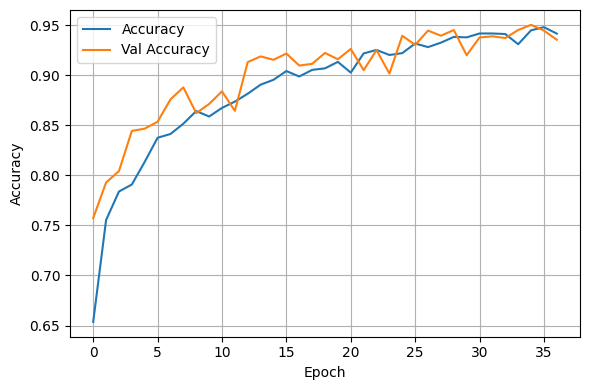

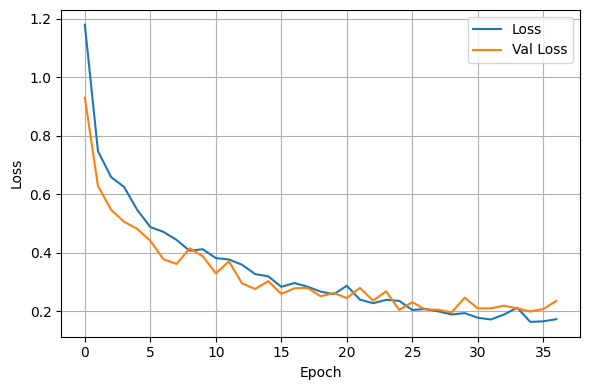

In [14]:
import matplotlib.pyplot as plt

def plot_history(history, metric='accuracy'):
    """Plot training & validation curves for a Keras History object."""
    plt.figure(figsize=(6,4))
    for k,v in history.history.items():
        if metric in k:                       # pick accuracy or loss keys
            label = k.replace('_',' ').title()
            plt.plot(v, label=label)
    plt.xlabel('Epoch'); plt.ylabel(metric.title())
    plt.grid(True); plt.legend(); plt.tight_layout()

plot_history(hist, metric='accuracy')
plot_history(hist, metric='loss')

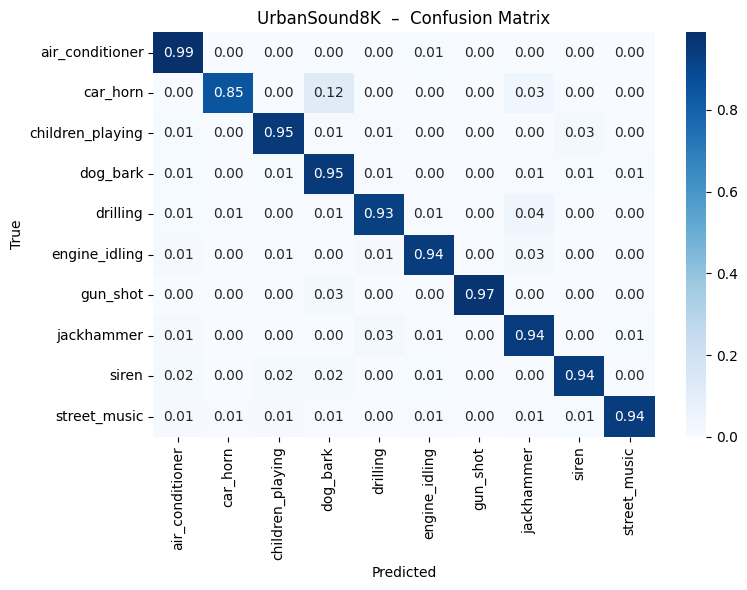

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Convert one-hot back to integer labels
y_val_int  = y_va.argmax(axis=1)

# Predict
y_pred_int = clf.predict(X_va, verbose=0).argmax(axis=1)

cm = confusion_matrix(y_val_int, y_pred_int)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)   # row-normalised

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt='.2f',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('UrbanSound8K  –  Confusion Matrix')
plt.tight_layout()

In [16]:
TEST_FOLD = 5

test_rows = meta_df[meta_df['fold'] == TEST_FOLD]
print(f"Using fold {TEST_FOLD}: {len(test_rows)} clips as test set")

X_test_emb, y_test_int = [], []

for _, row in tqdm(test_rows.iterrows(),
                   total=len(test_rows),
                   desc=f"YAMNet embeddings (fold {TEST_FOLD})"):
    wav = load_wav_16k(path_from_row(row))
    _, emb, _ = yamnet(wav)
    X_test_emb.append(tf.reduce_mean(emb, axis=0).numpy())
    y_test_int.append(le.transform([row['class']])[0])

X_test_emb = np.stack(X_test_emb)
y_test_cat = tf.keras.utils.to_categorical(y_test_int,
                                           num_classes=len(le.classes_))
print("Test tensor:", X_test_emb.shape, "Labels:", y_test_cat.shape)

Using fold 5: 936 clips as test set


YAMNet embeddings (fold 5):   0%|          | 0/936 [00:00<?, ?it/s]

Test tensor: (936, 1024) Labels: (936, 10)


Fold 5 – test accuracy: 96.47%


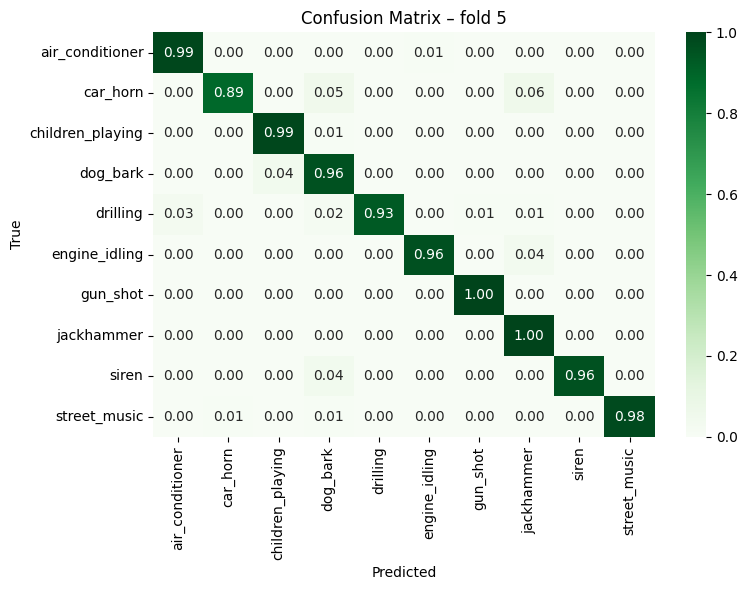

In [17]:
test_loss, test_acc = clf.evaluate(X_test_emb, y_test_cat, verbose=0)
print(f"Fold {TEST_FOLD} – test accuracy: {test_acc:.2%}")

from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

y_pred_int = clf.predict(X_test_emb, verbose=0).argmax(axis=1)
cm = confusion_matrix(y_test_int, y_pred_int)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt='.2f',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap='Greens')
plt.title(f'Confusion Matrix – fold {TEST_FOLD}')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout()

In [21]:
model.save("audio_modelv2.h5", include_optimizer=False)